# nav stok

In [15]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

"""
FEniCS tutorial demo program: Incompressible Navier-Stokes equations
for flow around a cylinder using the Incremental Pressure Correction
Scheme (IPCS).

  u' + u . nabla(u)) - div(sigma(u, p)) = f
                                 div(u) = 0
"""

"\nFEniCS tutorial demo program: Incompressible Navier-Stokes equations\nfor flow around a cylinder using the Incremental Pressure Correction\nScheme (IPCS).\n\n  u' + u . nabla(u)) - div(sigma(u, p)) = f\n                                 div(u) = 0\n"

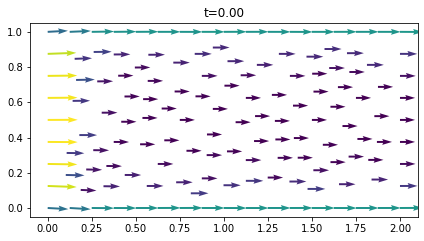

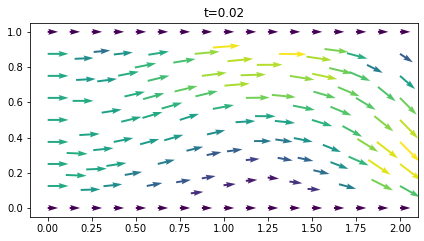

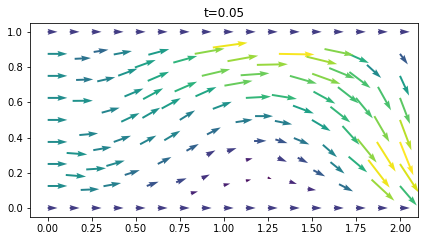

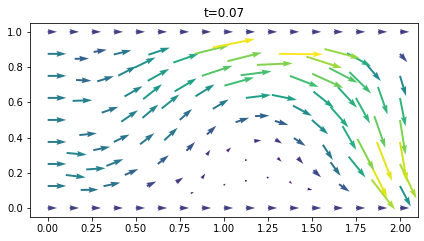

In [17]:
T = 0.1            # final time
num_steps = 200   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# mesh and spaces
channel = Rectangle(Point(0, 0), Point(2, 1))
cylinder = Circle(Point(2, 0.5), 0.4)
domain = channel #- cylinder
mesh = generate_mesh(domain, 10)
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)
# plot(mesh)

# BC
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2)'
walls    = 'near(x[1], 0) || near(x[1], 1)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'
bcu_walls = DirichletBC(V, Expression(("0.005","0"), degree=2), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcu_inflow = DirichletBC(V, Expression(("0.01","0"), degree=2), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
# bcu = [bcu_inflow_and_walls, bcu_cylinder]
bcu = [bcu_inflow, bcu_walls]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# lorentz term
# B = Constant((0,0,1))
B = Expression(("0","0","1*exp(-10*(pow((x[0]-1.5),2)+pow((x[1]-0.5),2)))"),degree=1)
uxB = as_vector(( u[1]*B[2], -u[0]*B[2] ))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx \
   + 100*dot(uxB,v)*dx 
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# files
# file_u = File("plots/u.pvd")

# Time-stepping
t = 0
fignr=1
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
#     print("hi1")
    solve(A3, u_.vector(), b3, 'cg', 'sor')
#     print("hi2")
    
    # save solution
#     file_u << u_n

    # Plot solution
    if n%(num_steps/4) == 0:
        plt.figure()
#         plot(mesh)
#         plot(u_, title='Velocity, t='+str(t)[:4])
        plot(u_, title='t='+str(t)[:4])
#         plot(p_, title='Pressure')
#         plt.show()
        plt.tight_layout()
        plt.savefig("plots/2Dnavstok_"+str(fignr)+".pdf")
#         plt.savefig("plots/plot_NS_"+str(fignr)+".pdf")
        fignr+=1
    
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

In [ ]:
from __future__ import print_function
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt

T = 0.1            # final time
num_steps = 200    # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# mesh and spaces
channel = Rectangle(Point(0, 0), Point(2, 1))
cylinder = Circle(Point(2, 0.5), 0.4)
domain = channel #- cylinder
mesh = generate_mesh(domain, 10)
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# BC
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2)'
walls    = 'near(x[1], 0) || near(x[1], 1)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'
bcu_walls = DirichletBC(V, Expression(("0.005","0"), degree=2), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcu_inflow = DirichletBC(V, Expression(("0.01","0"), degree=2), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
# bcu = [bcu_inflow_and_walls, bcu_cylinder]
bcu = [bcu_inflow, bcu_walls]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# lorentz term
B = Expression(("0","0","1*exp(-10*(pow((x[0]-1.5),2)+pow((x[1]-0.5),2)))"),degree=1)
uxB = as_vector(( u[1]*B[2], -u[0]*B[2] ))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx \
   + 100*dot(uxB,v)*dx 
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# Time-stepping
t = 0
fignr=1
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3, 'cg', 'sor')

    # Plot solution
    if n%(num_steps/4) == 0:
        plt.figure()
        plot(u_, title='t='+str(t)[:4])
        plt.tight_layout()
        fignr+=1
    
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)